In [1]:
from fromscratchtoml.neural_network.models import Sequential
from fromscratchtoml.neural_network.optimizers import StochasticGradientDescent
from fromscratchtoml.neural_network.layers import Dense, Activation

import numpy as np
from sklearn.model_selection import train_test_split

from fromscratchtoml.toolbox.random import Distribution
from fromscratchtoml.toolbox.preprocess import to_onehot

In [28]:
from sklearn import datasets
from sklearn.utils import shuffle

from fromscratchtoml.toolbox import binary_visualize

import matplotlib.pyplot as plt
%matplotlib inline

# Neural Networks

## Fitting a XOR gate

In [3]:
model1 = Sequential()
model1.add(Dense(5, input_dim=2, seed=1))
model1.add(Activation('sigmoid'))
model1.add(Dense(5, seed=2))
model1.add(Activation('sigmoid'))
model1.add(Dense(2, seed=3))
sgd = StochasticGradientDescent(learning_rate=0.1)
model1.compile(optimizer=sgd, loss="mean_squared_error")

In [4]:
X1 = np.array([[0, 0],[0, 1],[1, 0], [1, 1]])
y1 = np.array([[1,0], [0,1], [0,1], [1,0]])
y1

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0]])

In [5]:
%time model1.fit(X1, y1, batch_size=4, epochs=100)

[███████████████████████████████████████ ] 99% 
epoch: 100/100  acc: 100.00  loss: 0.000 
[████████████████████████████████████████] 100% CPU times: user 103 ms, sys: 12.6 ms, total: 115 ms
Wall time: 169 ms


In [6]:
model1.layers[-1].biases

array([[1.346127  , 2.11858538]])

In [7]:
model1.layers[-1].weights

array([[-1.13710606, -0.4548632 ],
       [-0.46534801, -2.15876972],
       [-0.88261708, -0.40209691],
       [ 1.06302935,  0.20252469],
       [-1.55501902,  0.83763579]])

In [8]:
model1.predict(X1, one_hot=True)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

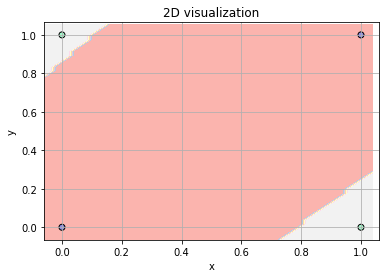

In [9]:
binary_visualize(X1, clf=model1, draw_contour=True)

## MNIST Digit Classification

In [12]:
from sklearn.datasets import fetch_mldata
from skimage.color import gray2rgb, rgb2gray, label2rgb

mnist = fetch_mldata('MNIST original', data_home=".")
print(len(mnist.data))
X2 = mnist.data/256.

70000


In [13]:
X2 = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0)
y2 = mnist.target.astype(np.uint8)

In [14]:
makegray_step = lambda img_list: [rgb2gray(img) for img in img_list]
flatten_step = lambda img_list: [img.ravel() for img in img_list]

In [15]:
def lime_wrapper(x, one_hot=1):
    x = makegray_step(x)
    x = flatten_step(x)
    return model2.predict(x, one_hot=one_hot)

In [16]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=60000, random_state=42)
X_train2.shape, y_train2.shape

((10000, 28, 28, 3), (10000,))

In [17]:
model2 = Sequential(verbose=True)
model2.add(Dense(30, input_dim=784, seed=10))
model2.add(Activation('sigmoid'))
model2.add(Dense(10, seed=10))
model2.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=1)
model2.compile(optimizer=sgd, loss="mean_squared_error")

In [19]:
%time model2.fit(np.array(flatten_step(makegray_step(X_train2))), to_onehot(y_train2), batch_size=10, epochs=5)


epoch: 1/5  acc: 83.62  loss: 0.033 
[████████                                ] 20% 
epoch: 2/5  acc: 89.12  loss: 0.022 
[████████████████                        ] 40% 
epoch: 3/5  acc: 90.61  loss: 0.019 
[████████████████████████                ] 60% 
epoch: 4/5  acc: 91.02  loss: 0.018 
[████████████████████████████████        ] 80% 
epoch: 5/5  acc: 91.99  loss: 0.016 
[████████████████████████████████████████] 100% CPU times: user 27.9 s, sys: 549 ms, total: 28.4 s
Wall time: 27.8 s


In [20]:
model2.accuracy(np.array(flatten_step(makegray_step(X_test2))), to_onehot(y_test2))

90.18166666666667

## Explaining predictions with LIME.

In [21]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=20, ratio=0.2)

In [38]:
%%time
explanation = explainer.explain_instance(X_test2[10], 
                                         classifier_fn = lime_wrapper, 
                                         top_labels=10, hide_color=0, num_samples=10, segmentation_fn=segmenter)

CPU times: user 34.9 ms, sys: 394 µs, total: 35.3 ms
Wall time: 33.2 ms


Text(0.5,1,'Positive/Negative Regions for 4')

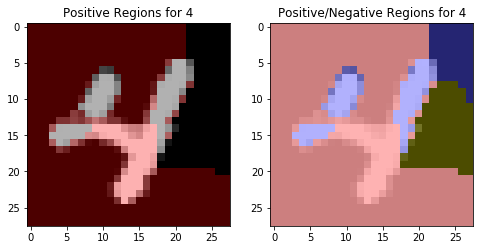

In [39]:
temp, mask = explanation.get_image_and_mask(y_test2[10], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test2[10]))
temp, mask = explanation.get_image_and_mask(y_test2[10], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test2[10]))

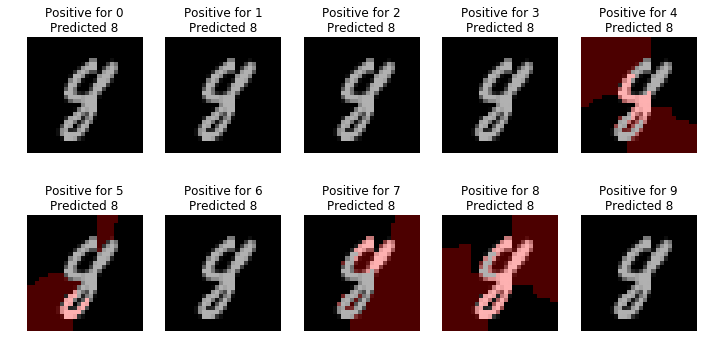

In [36]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
ind = 781

explanation = explainer.explain_instance(X_test2[ind], 
                                         classifier_fn = lime_wrapper, 
                                         top_labels=10, hide_color=0, num_samples=10, segmentation_fn=segmenter)

for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test2[ind], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nPredicted {}'.format(i, lime_wrapper([X_test2[ind]], one_hot=0)[0]))
    c_ax.axis('off')

## Training a single perceptron

In [ ]:
model3 = Sequential()
model3.add(Dense(1, input_dim=1, seed=10))
model3.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.5)
model3.compile(optimizer=sgd, loss="mean_squared_error")

In [ ]:
X3 = np.array([1])
y3 = np.array([0.2])

In [ ]:
%time model3.fit(X3, y3, epochs=200)

In [ ]:
model3.forwardpass(X3)

## Iris Dataset

In [ ]:
iris = datasets.load_iris()

X4 = iris.data[:, :2]
Y4 = to_onehot(iris.target[:])
X4, Y4 = shuffle(X4, Y4, random_state=10)

Xtrain4 = X4[:120]
Ytrain4 = Y4[:120]
Xtest4 = X4[120:]
Ytest4 = Y4[120:]

In [ ]:
model4 = Sequential()
model4.add(Dense(5, input_dim=2, seed=1))
model4.add(Activation('sigmoid'))
model4.add(Dense(3, seed=2))
model4.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.1)
model4.compile(optimizer=sgd, loss="mean_squared_error")

In [ ]:
%time model4.fit(Xtrain4, Ytrain4, epochs=100)

In [ ]:
model4.predict(Xtrain4[:5], one_hot=True), Ytest4[:5]

In [ ]:
binary_visualize(Xtest4, clf=model4, draw_contour=True)

In [ ]:
binary_visualize(Xtest4, Ytest4)

## Radial

In [ ]:
X11 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=1,
               ed=2, seed=20)
X22 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=4,
               ed=5, seed=20)

Y11 = np.ones(X11.shape[0])
Y22 = np.zeros(X11.shape[0])

X5 = np.vstack((X11, X22))
y5 = np.hstack((Y11, Y22))

In [ ]:
y5 = to_onehot(y5)

In [ ]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=50, random_state=42)

In [ ]:
y_train5.shape

In [ ]:
model5 = Sequential(verbose=1, vis_each_epoch=True)
model5.add(Dense(10, input_dim=2, seed=1))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=2))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=3))
# model5.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.05)
model5.compile(optimizer=sgd, loss="mean_squared_error")

In [ ]:
%time model5.fit(X_train5, y_train5, epochs=5)

In [ ]:
binary_visualize(X_test5, clf=model5, draw_contour=True)